### GovInvest Programming Assignment

#### Directions

The task is to develop an algorithm, implemented in Python, that will create a data file for Test City as of June 30, 2016, assuming that:
 
* Demographic experience matches CalPERS assumptions
* The number of active members in Test City stays constant from year to year.

New members have the demographic characteristics of the most recent active hire in the existing data file

The data files provided are:
* “Data_file”, representing a snapshot of a pension plan demographic for Test City as of June 30, 2015. Current and former Test City employees are members of CalPERS.
* “Rate_reference”, representing various actuarial rates that are used by the CalPERS pension system in California.



In [838]:
#We import the libraries we are going to use
%matplotlib inline

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
plt.style.use('ggplot')
pd.options.mode.chained_assignment = None

In [839]:
# we import the data into a pandas Data Frame
df=pd.read_csv('data_file.csv', sep=',', na_values=['n/a'], keep_default_na=False)

In [840]:
# we import the Reference Rates ('rate_references.csv')  and Mortality and Disability Rate ('MortalityDisability.csv') 
# into a pandas Data Frame
# The File "Readme Variables" includes the variable description for both files. 
refrates=pd.read_csv('rate_references.csv', sep=',', na_values=['n/a'], keep_default_na=False)
mortdisab=pd.read_csv('MortalityDisability.csv', sep=',', na_values=['n/a'], keep_default_na=False)

In [841]:
# We need to convert the dates as python`s datetime
df['birth_date'] = pd.to_datetime(df['birth_date'])
df['hire_date'] = pd.to_datetime(df['hire_date'])

##### In the following lines we inspect the files

In [842]:
df.head()

,id,gender,status,group,birth_date,hire_date,service_in_city,benefit_formula_benefit_factor,benefit_formula_retirement_age,life_annuity_yearly_amount
0,1,f,active,miscellaneous,1950-01-09,2004-07-12,11.18,2.00%,55.0,0
1,2,m,active,miscellaneous,1978-01-22,2007-02-07,8.61,2.50%,55.0,0
2,3,f,active,miscellaneous,1950-08-24,2000-10-10,15.34,2.50%,55.0,0
3,4,m,active,miscellaneous,1972-01-14,1990-10-09,23.86,2.70%,55.0,0
4,5,f,active,miscellaneous,1980-04-24,1997-11-17,14.61,3.00%,60.0,0


In [843]:
refrates.head()

,Service,TR_15,TR_16,TR_17,TR_18,TR_19,TR_20,TR_21,TR_22,TR_23,...,RXM3_60__70,RXM3_60__71,RXM3_60__72,RXM3_60__73,RXM3_60__74,RXM3_60__75,RXM3_60__76,RXM3_60__77,RXM3_60__78,RXM3_60__79
0,0,0.1812,0.1798,0.1784,0.1770,0.1756,0.1742,0.1730,0.1716,0.1702,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.1615,0.1601,0.1587,0.1573,0.1559,0.1545,0.1532,0.1519,0.1505,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.1418,0.1404,0.1390,0.1376,0.1362,0.1348,0.1335,0.1322,0.1308,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.1221,0.1207,0.1193,0.1179,0.1165,0.1151,0.1138,0.1125,0.1111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.1024,0.1010,0.0996,0.0982,0.0968,0.0954,0.0940,0.0928,0.0914,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [844]:
mortdisab.tail()

,AA,PRNIDM,PRIDM,PRNIDF,PRIDF,PoRHM,PoRNIDiM,PoRIDiM,PoRHF,PoRNIDiF,PoRIDiF,DNIDM,DIDM,DNIDF,DIDF
115,116,0.0,0,0.0,0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0,0.0,0
116,117,0.0,0,0.0,0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0,0.0,0
117,118,0.0,0,0.0,0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0,0.0,0
118,119,0.0,0,0.0,0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0,0.0,0
119,120,0.0,0,0.0,0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0,0.0,0


In [845]:
# This function calculate the age based on a date. 
# The correct way to do this is to calculate the age 
# by subtracting the two years (ex. Date as of June 30, 2015 - birth_date ), and then 
# subtracting one if the current month/day precedes the birth month/day.
def age(dob, datadf = date(2015, 6, 30)): #Default date of the snapshot (June 30, 2015)
    import datetime
    if datadf.month < dob.month | \
      (datadf.month == dob.month & datadf.day < dob.day):
        #We subtract one because the current month/day precedes the birth month/day
        return int(datadf.year - dob.year - 1)    
    else:
        return int(datadf.year - dob.year)

In [846]:
# We add the age columns in the Data Frame
df['age_df_date'] = df.birth_date.apply(age).astype(int) #The age as of June 30, 2015 
df['age_df_date_proj'] = df['age_df_date']+1 #The age as of June 30, 2016


#Another way to calculate the entry age into the plan based in two columns considering int(True) is 1 and int(False) is 0
df['age_at_hire']=df.apply(lambda x: x['hire_date'].year - x['birth_date'].year - 
                           ((x['hire_date'].month, x['hire_date'].day) < (x['birth_date'].month, x['birth_date'].day)), axis=1)



#### I perform some basic exploratory analysis of the data

In [847]:
# Contingency tables to have an insight into the relationship between Status and Gender. 
# Calculating the absolute values
status_gender = pd.crosstab(index=df["status"], columns=df["gender"])
status_gender.index= ["Active","Retired"]
status_gender.columns=["Female", "Male"]
status_gender

,Female,Male
Active,5,4
Retired,3,0


In [848]:
# Contingency tables to have an insight into the relationship between Status and Gender. 
# Calculating the percentages by by columns axis = 0
# if you want to calculate the percenteges by rows then axis = 1 
status_gender1=pd.crosstab(index=df["status"], columns=df["gender"]).apply(lambda r: r/r.sum(), axis=0)
status_gender1.index= ["Active","Retired"]
status_gender1.columns=["Female", "Male"]
status_gender1

,Female,Male
Active,0.625,1.0
Retired,0.375,0.0


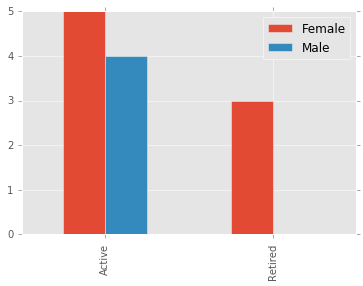

In [849]:
status_gender.plot(kind='bar')

In [850]:
# Statistics of Years of Service and Age as of June 30, 2015 for the active population
# 25%, 50%, and 75% are percentiles 
df[['service_in_city','age_df_date','age_at_hire']].dropna().describe() #we drop NA to calcualte this statistics

,service_in_city,age_df_date,age_at_hire
count,9.000000,9.000000,9.000000
mean,11.570000,46.444444,35.111111
std,7.035494,11.533767,13.513368
min,2.900000,34.000000,17.000000
25%,4.770000,37.000000,29.000000
50%,11.180000,43.000000,31.000000
75%,15.340000,50.000000,48.000000
max,23.860000,65.000000,54.000000


##### In the following lines we are going to include the columns associated to the Multiple Decrements based on:
* several causes of decrement
* probabilities of decrement
Multiple decrement models are extensions of standard mortality models whereby there is simultaneous operation of several causes of decrement. A life fails because of one of these decrements. In this particular case a life fails means that a member will not continue in the plan due to:
1) Mortality
2) Disability
3) Terminated Refund 
4) Terminated Vested 
5) Service Retirement


#### I am going to create some functions to retrive the reference rates

In [851]:
# Based on the notes 2 and 4 of the mortality and disability file Miscellaneous Plans usually have Industrial Death rates set 
# to zero unless the agency has specifically contracted for Industrial Death benefits and normally, Industrial Disability rates
# are zero for miscellaneous plans. 
# I am assuming no Industrial Death Benefits neither Industrial Disability rates were contracted.
# The Pre-Retirement Mortality is based only on the Non Industrial Death by Gender
# I am assuming the retired members are healthy since no other information is given.
# Note: It is possible to make one python class including all the following functions. However, for this implementation
# I do a function for each of the decrements in order to be more clear


#Function to get the mortality rate according to the gender, status and age

def getmortality(df):  #df is the data DataFrame 
    mortdis=mortdisab #mortdisab is the mortality and disability data frame
    if (df['gender'] =='m' and df['status'] =='active'): #According to the gender and status, we select the mortality rate
        rate='PRNIDM'  #Pre-Retirement Mortality Non Industrial Death Male
    elif (df['gender'] =='f' and df['status'] =='active') :
        rate='PRNIDF'   #Pre-Retirement Mortality Non Industrial Death Female
    elif (df['gender'] =='m' and df['status'] =='retired') :
        rate='PoRHM' #Post-Retirement Mortality Healthy Recipients Male
    else:
        rate='PoRHF' #Post-Retirement Mortality Healthy Recipients Female 
    return mortdis[rate].loc[mortdis['AA'] == df['age_df_date']] #We find the age of each member and return the mortality rate

In [852]:
#Function to get the disability rate according to the gender and age

def getdisability(df):  #df is the data DataFrame 
    mortdis=mortdisab #mortdisab is the mortality and disability data frame
    if df['gender'] =='m': #According to the gender, we select the mortality rate
        rate='DNIDM' #Non Industrial Disability Male
    else:
        rate='DNIDF' #Non Industrial Disability Female
    if df['status'] =='active':
        return mortdis[rate].loc[mortdis['AA'] == df['age_df_date']]  #We find the age of member and return the disability rate
    else:
        return float('NaN')

In [853]:
#Function to get the terminated refund rates according to the Years of Service and entry age
# I am assuming the Years of Service are rounded to the nearest integer

def gettermrefund(df):  #df is the data DataFrame 
    refrates_=refrates #DataFrame containing assumptions of the references rates
    try:
        entryage= 'TR_' + str(int(df['age_at_hire'])) #We find the entry age and transform to a string to find the rate (column)
    except ValueError:
        return 0
    return refrates_[entryage].loc[refrates_['Service'] == int(round(df['service_in_city'],0))] #Years of Service  
                                                                                            #rounded the nearest integer

In [854]:
#Function to get the terminated vested rates according to the Years of Service and entry age
# I am assuming the Years of Service are rounded to the nearest integer

def gettermvested(df):  #df is the data DataFrame 
    refrates_=refrates #DataFrame containing assumptions of the references rates
    try:
        entryage= 'TV_' + str(int(df['age_at_hire'])) #We find the entry age and transform to a string to find the column 
    except ValueError:
        return 0
    return refrates_[entryage].loc[refrates_['Service'] == int(round(df['service_in_city'],0))]   #Years of Service  
                                                                                            #rounded the nearest integer

In [855]:
#Function to get the Service Retirement rates according to the Years of Service and Attained Ages 
# if the age is less than 50, I am assuming the Service Retirement rate is zero.

def getservret(df):  #df is the data DataFrame 
    refrates_=refrates #DataFrame containing assumptions of the references rates
    #According to the gender, we select the mortality rate
    try:
        if (df['benefit_formula_benefit_factor'] == '2.00%' and df['benefit_formula_retirement_age'] == 60 ): 
            rate='RXM2_60__' + str(int(df['age_df_date']))
        elif (df['benefit_formula_benefit_factor'] == '2.00%' and df['benefit_formula_retirement_age'] == 55 ): 
            rate='RXM2_55__' + str(int(df['age_df_date']))
        elif (df['benefit_formula_benefit_factor'] == '2.50%' and df['benefit_formula_retirement_age'] == 55 ): 
            rate='RXM25_55__' + str(int(df['age_df_date']))
        elif (df['benefit_formula_benefit_factor'] == '2.70%' and df['benefit_formula_retirement_age'] == 55 ): 
            rate='RXM27_55__' + str(int(df['age_df_date']))
        elif (df['benefit_formula_benefit_factor'] == '3.00%' and df['benefit_formula_retirement_age'] == 60 ): 
            rate='RXM3_60__' + str(int(df['age_df_date']))
        else: 
            rate='RXM2_62__' + str(int(df['age_df_date']))
        return refrates_[rate].loc[refrates_['Service'] == int(round(df['service_in_city'],0))] 
    except:
        return 0

#### The following code add columns applying the functions to get the references rates 

In [856]:
df['survprob']=1-df.apply(getmortality,axis=1).fillna(0).sum(axis=1) #We create a column with the survival rates 
df['disab_pre']=1-df.apply(getdisability,axis=1).fillna(0).sum(axis=1) #We create a column with the disability rates
df['term_ref']=1-df.apply(gettermrefund,axis=1).fillna(0).sum(axis=1) #We create a column with the terminated refund rates
df['term_vest']=1-df.apply(gettermvested,axis=1).fillna(0).sum(axis=1) #We create a column with the terminated vested rates
df['serv_rate']=1-df.apply(getservret,axis=1).fillna(0).sum(axis=1) #We create a column with the Service Retirement rates 
df.disab_pre[df.status == 'retired'] = 'NaN'
df.term_ref[df.status == 'retired'] = 'NaN'
df.term_vest[df.status == 'retired'] = 'NaN'
df.serv_rate[df.status == 'retired'] = 'NaN'


The probability that a member (x) will leave the group within one year as a result of decrement j is $$ q_x^{j} $$
The probability that a member (x) will leave the group (regardless of decrement) is:
$$q_x^{T} = \sum_{j=1}^{m} q_x^{j} $$ 
The probability that (x) will remain in the group for at least one year (Kaplan-Meier Estimator): 
$$p_x^{T} = 1-q_x^{T} $$ 

I am assuming  a  uniform distribution of decrement in the interval (x, x+1) and assuming that the decrement ocurr at the end of the year.

Additionally, I am assuming the rates given are the dependent rates.

In [857]:
#Function to get the total survival probability Kaplan-Meier Estimator
def gettotprobkp(df):  #df is the data DataFrame 
    if df['status']=='active': #if the member is active then we multiply all the decrements 
        return 1-((1-df['survprob'])+(1-df['disab_pre'])+(1-df['term_ref'])+(1-df['term_vest'])+(1-df['serv_rate']))
    else:    #if the member is retired then we only have the mortality rate
        return df['survprob']

In [858]:
df['tot_surv_kp']=df.apply(gettotprobkp,axis=1)#We create a column to display the total survival probability assuming KM
                                            #probability that (x) will remain in the group for at least one year:)

We need to find the total number of new members. In order to get this, we need to find how many members leave the plan by adding the total survival probabilities. 

In [860]:
# sum of total survival probabilities.
df.loc[df['status'] == 'active', 'tot_surv_kp'].sum()

8.24657

So, we need to add 0.7534299999999998 new members in the plan (Total number of active members year 0 - Total number of active members year 1) (9 - 8.24657 = 0.7534299999999998 )

If we assume that each row represents 100 members then:

In [861]:
df['number_members_at_2015']=100 #Number of member as of June 30, 2015
df['number_members_at_2016']=df['number_members_at_2015']*df['tot_surv_kp'] #Number of member as of June 30, 2015
df['number_members_at_2016']=df['number_members_at_2016'].apply(lambda x:round(x,0)) #Round the number of members to 0 decimals

In [862]:
# sum of total members.
df.loc[df['status'] == 'active', 'number_members_at_2016'].sum()

824.0

So, I need to add 76 new members in the plan (Total number of active members year as of June 30, 2015  - Total number of active members year s of June 30, 2016) (900-824=76). This is because of the assumption that the number of active members in Test City stays constant from year to year. New members have the demographic characteristics of the most recent active hire in the existing data file

In [877]:
# We need to get the new members demographic characteristics, according the the assumptions 
#New members have the demographic characteristics of the most recent active hire in the existing data file
# We need to find the most recent active hire.
#The following lines creates a data frame where the row represent the new members
#We find the index of the most recent hire, then using list comprehension we iterate over the values of the most recent hire.
newmembers=pd.DataFrame(df.iloc[df[df['hire_date'] == max(df['hire_date'])].index.tolist()[0]][i] 
            for i in xrange(len(list(df)))).T
newmembers.columns=list(df)
#In the following lines we adjust some characteristics
newmembers['id']=max(df['id'])+1 #we set the id of the new members as the last id + 1
newmembers['hire_date'] =datetime.datetime(2016,6,30)#I am assuming the new members are hire exactly on June 30, 2016
newmembers['service_in_city']=0 #Because if the previous assumption the service is 0 as of June 30, 2016
newmembers['number_members_at_2015']=0 #The number of members as of June 30, 2015 is zero.
newmembers['number_members_at_2016']= df.loc[df['status'] == 'active', 'number_members_at_2015'
                                            ].sum()- df.loc[df['status'] == 'active', 'number_members_at_2016'].sum() 
newmembers[['survprob','disab_pre','term_ref','term_vest','serv_rate','tot_surv_kp']]=1 #I set all the probabilities equal =1 
                                                                    #since the new memberes are just starting in the plan
newmembers['age_at_hire']=newmembers['age_df_date_proj'] #we adjust the entry age

In [878]:
new_df=newmembers.append(df, ignore_index=True) #We add the new members to the data file.

In [879]:
new_df.head()

,id,gender,status,group,birth_date,hire_date,service_in_city,benefit_formula_benefit_factor,benefit_formula_retirement_age,life_annuity_yearly_amount,...,age_df_date_proj,age_at_hire,survprob,disab_pre,term_ref,term_vest,serv_rate,tot_surv_kp,number_members_at_2015,number_members_at_2016
0,13,m,active,miscellaneous,1964-12-09 00:00:00,2016-06-30,0.00,3.00%,60,0,...,51,51,1,1,1,1,1,1,0,76.0
1,1,f,active,miscellaneous,1950-01-09 00:00:00,2004-07-12,11.18,2.00%,55,0,...,66,54,0.99743,0.99882,0.9982,1,0.795,0.78945,100,79.0
2,2,m,active,miscellaneous,1978-01-22 00:00:00,2007-02-07,8.61,2.50%,55,0,...,38,29,0.99935,0.99926,0.9879,0.9557,1,0.94221,100,94.0
3,3,f,active,miscellaneous,1950-08-24 00:00:00,2000-10-10,15.34,2.50%,55,0,...,65,50,0.99759,0.9988,0.9996,1,0.847,0.84299,100,84.0
4,4,m,active,miscellaneous,1972-01-14 00:00:00,1990-10-09,23.86,2.70%,55,0,...,44,18,0.99906,0.99829,0.9977,0.9732,1,0.96825,100,97.0


In [881]:
new_df.to_csv('New_data_File.csv',sep=',',header=True,na_rep="NaN",  index=False) #We import the new data file to a csv 
                                                                                     #in the same directory